# Time Series forecasting with LSTM


## Table of content
1. [Libraries](#libraries)
2. [Read Data](#data)
3. [Feature Engineering](#feature)
4. [Exploratory Data Analysis](#eda)
5. [LSTM model](#lstm)
6. [PREDICTION](#prediction)

### Libraries<a id="libraries"></a>

In [1]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns 
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

### Read data<a id="data"></a>

In [2]:
df=pd.read_csv('household_power_consumption.txt',delimiter=';')

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


### Feature Engineering<a id="feature"></a>

In [3]:
# sắp xếp theo cột 'date_time', chỉ chứa cột 'date_time' và 'Global_active_power', và các hàng có giá trị NaN trong cột 'Global_active_power' bị loại bỏ.
# Tạo một cột mới'date_time', trong đó giá trị của mỗi hàng được tạo bằng cách kết hợp giá trị từ cột 'Date' và 'Time'
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
#  Chuyển đổi giá trị trong cột 'Global_active_power' thành kiểu số
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_active_power']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)

In [4]:
#Tạo một cột mới trong DataFrame có tên là 'year', trong đó giá trị của mỗi hàng được lấy từ năm của cột 'date_time'. 
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Số hàng và cột sau khi loại bỏ các giá trị còn thiếu:',df.shape)
print('Chuỗi thời gian bắt đầu từ:',df['date_time'].min())
print('Chuỗi thời gian kết thúc vào:',df['date_time'].max())

Số hàng và cột sau khi loại bỏ các giá trị còn thiếu: (2049280, 7)
Chuỗi thời gian bắt đầu từ: 2006-12-16 17:24:00
Chuỗi thời gian kết thúc vào: 2010-11-26 21:02:00


In [5]:
#kiểm tra xem cột 'Global_active_power' có tuân theo phân phối Gaussian hay không
stat,p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.6f' %(stat,p))
alpha=0.05
if p>alpha :
  print('Data looks Gaussian(fail to reject H0)')
else:
  print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000000
Data does not look Gaussian (reject H0)


In [6]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_time            datetime64[ns]
 1   Global_active_power  float64       
 2   year                 int64         
 3   quarter              int64         
 4   month                int64         
 5   day                  int64         
 6   weekday              int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4)
memory usage: 101.6 MB


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
5,2006-12-16 17:29:00,3.5200,2006,4,12,16,0
6,2006-12-16 17:30:00,3.7020,2006,4,12,16,0
7,2006-12-16 17:31:00,3.7000,2006,4,12,16,0
8,2006-12-16 17:32:00,3.6680,2006,4,12,16,0
9,2006-12-16 17:33:00,3.6620,2006,4,12,16,0


### Exploratory Data Analysis<a id="eda"></a>

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320818


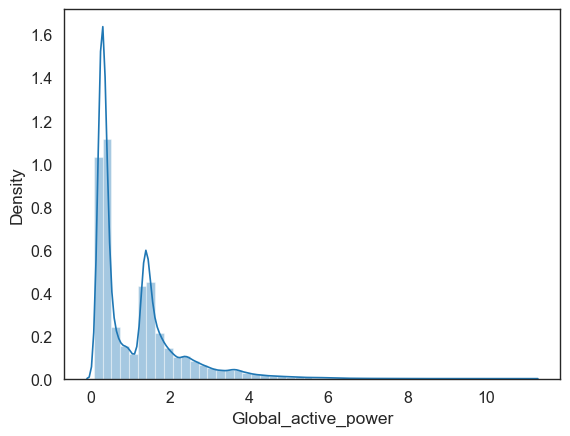

In [7]:
# vẽ đồ thị phân phối của cột 'Global_active_power' 
sns.distplot(df.Global_active_power)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

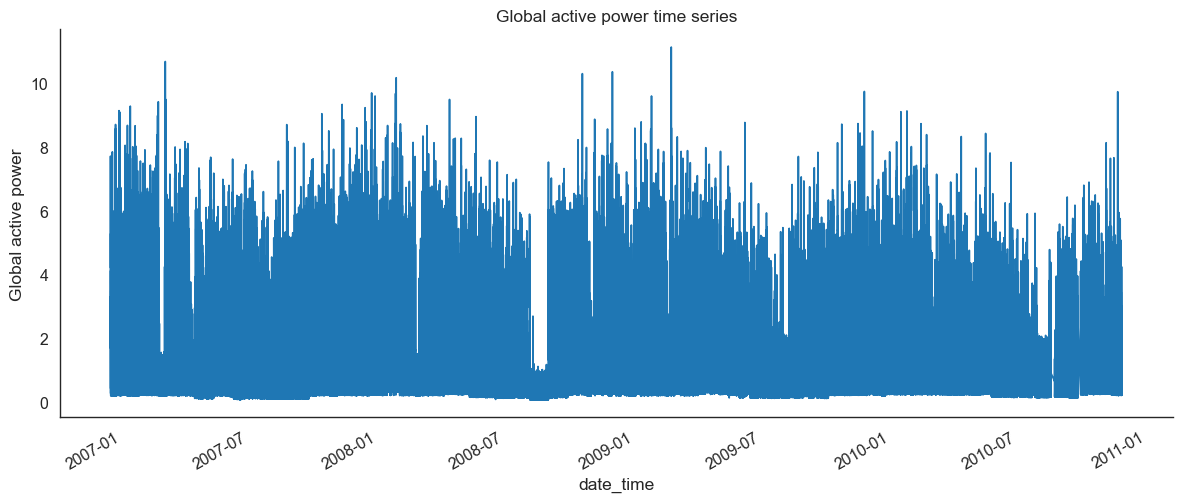

In [8]:
#Tạo một DataFrame mới có tên là df1, chỉ chứa cột 'date_time' và 'Global_active_power' từ DataFrame ban đầu
df1=df.loc[:,['date_time' ,'Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global active power time series')
sns.despine(top=True)
plt.show()

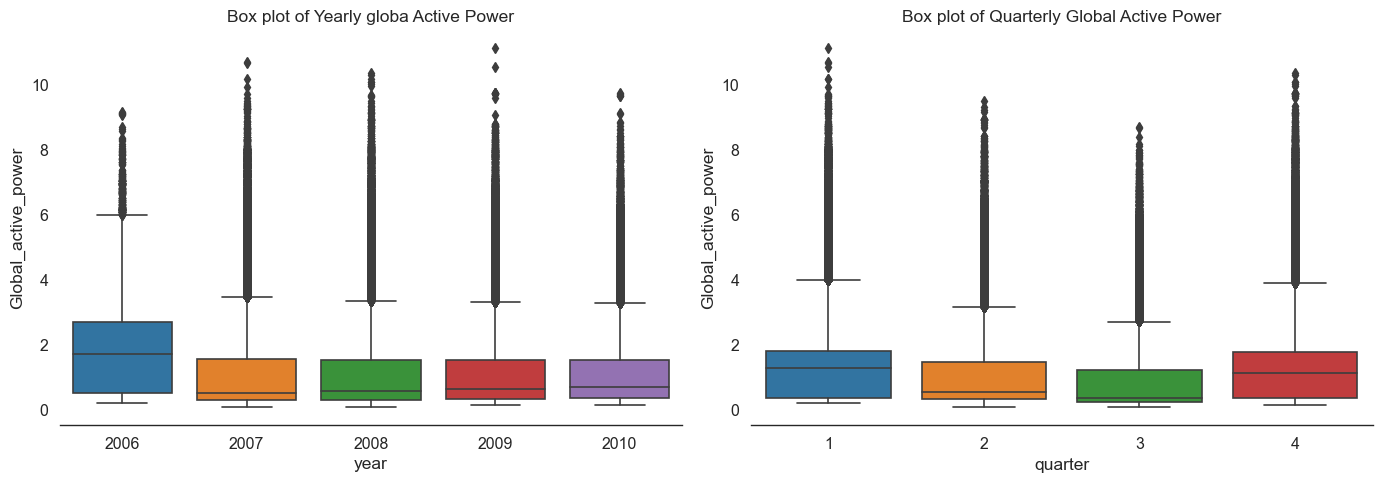

In [9]:
#Vẽ biểu đồ hộp cho cột 'Global_active_power' theo từng năm
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Global_active_power',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly globa Active Power')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Global_active_power',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


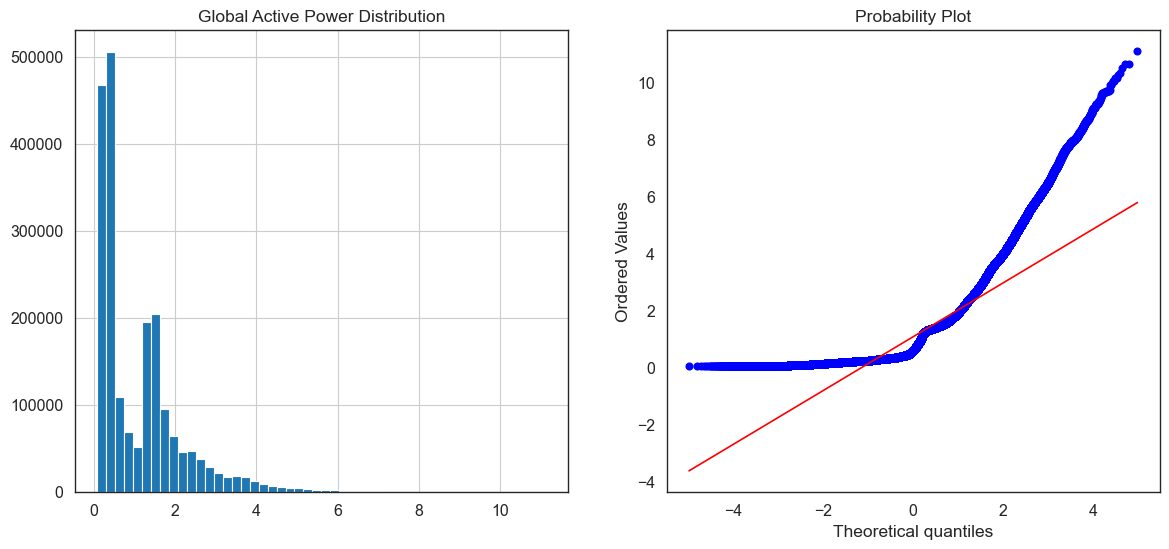

In [10]:
# Kiểm tra phân phối
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt)
df1.describe().T

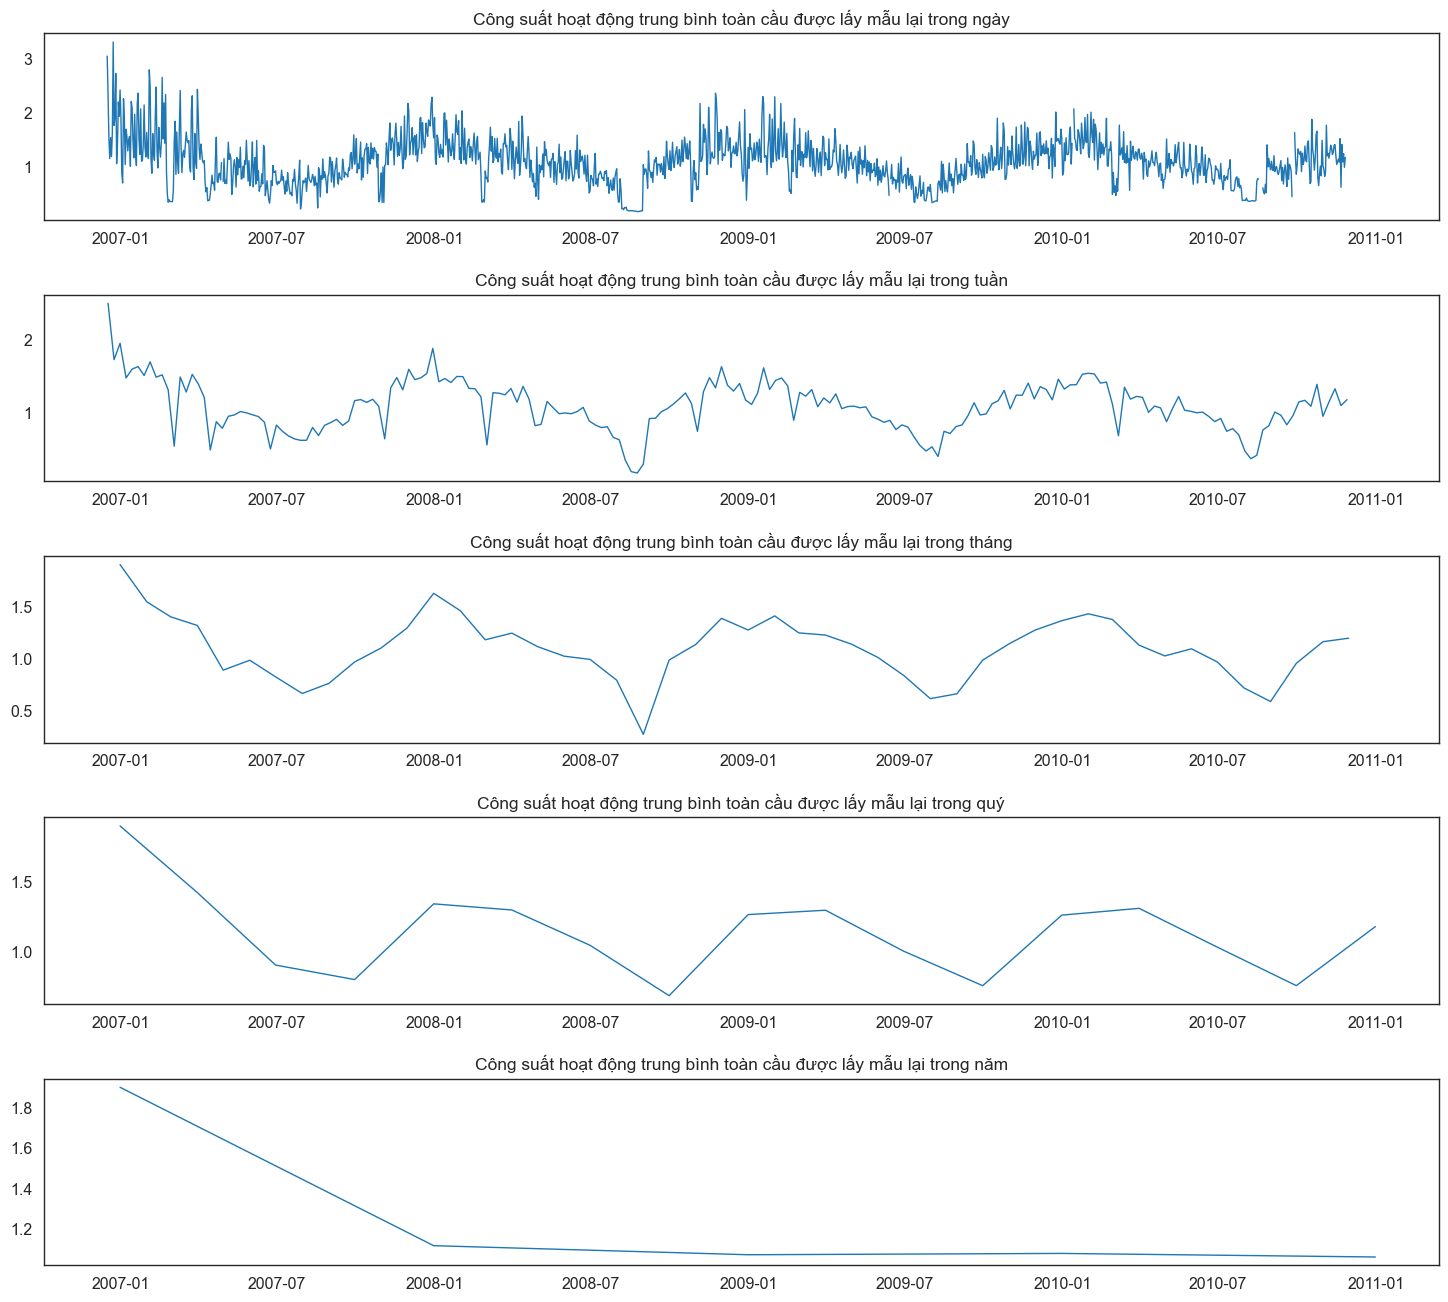

In [11]:
#Vẽ đồ thị dạng đường cho giá trị trung bình hàng ngày, hàng tuần, hàng tháng, hàng quý và hàng năm của 'Global_active_power'
fig=plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=0.4)
ax1=fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Công suất hoạt động trung bình toàn cầu được lấy mẫu lại trong ngày')
ax1.tick_params(axis='both',which='major')

ax2=fig.add_subplot(5,1,2,sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Công suất hoạt động trung bình toàn cầu được lấy mẫu lại trong tuần')
ax2.tick_params(axis='both',width='major')

ax3=fig.add_subplot(5,1,3,sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title("Công suất hoạt động trung bình toàn cầu được lấy mẫu lại trong tháng")
ax3.tick_params(axis='both',which='major')

ax4=fig.add_subplot(5,1,4,sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Công suất hoạt động trung bình toàn cầu được lấy mẫu lại trong quý')
ax4.tick_params(axis='both',which='major')
ax5=fig.add_subplot(5,1,5,sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Công suất hoạt động trung bình toàn cầu được lấy mẫu lại trong năm')
ax5.tick_params(axis='both',which='major')

Text(0.5, 1.0, 'Công suất hoạt động trung bình toàn cầu theo ngày')

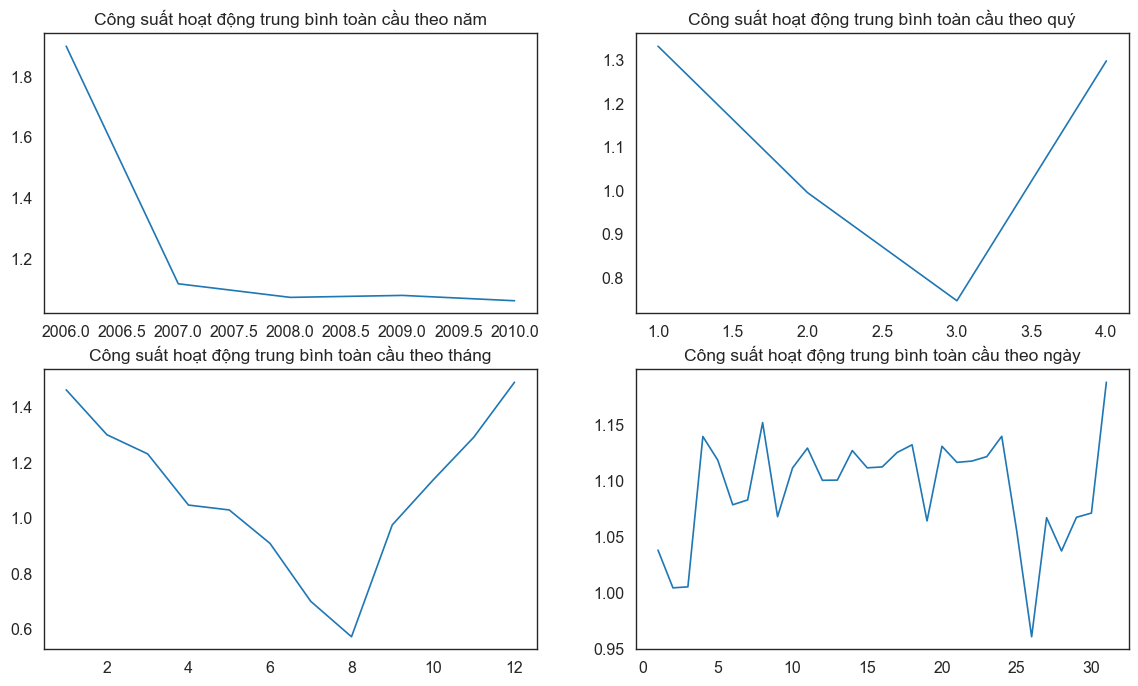

In [12]:
# năng lượng hoạt động toàn cầu được nhóm theo năm, quý, tháng và ngày

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Công suất hoạt động trung bình toàn cầu theo năm')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Công suất hoạt động trung bình toàn cầu theo quý')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Công suất hoạt động trung bình toàn cầu theo tháng')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Công suất hoạt động trung bình toàn cầu theo ngày')

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>, <Axes: xlabel='month'>,
        <Axes: xlabel='month'>]], dtype=object)

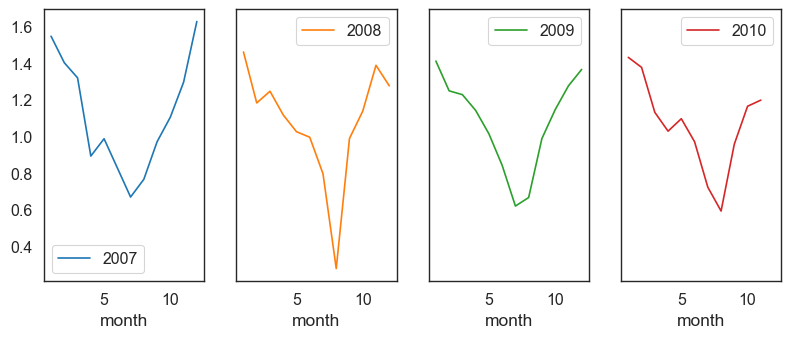

In [13]:
#đồ thị cho giá trị 'Global_active_power' được vẽ theo từng tháng trong từng năm (từ 2007 đến 2010)
pd.pivot_table(df.loc[df['year']!=2006],values='Global_active_power',columns='year',index='month').plot(subplots=True,figsize=(12,12),layout=(3,5),sharey=True)

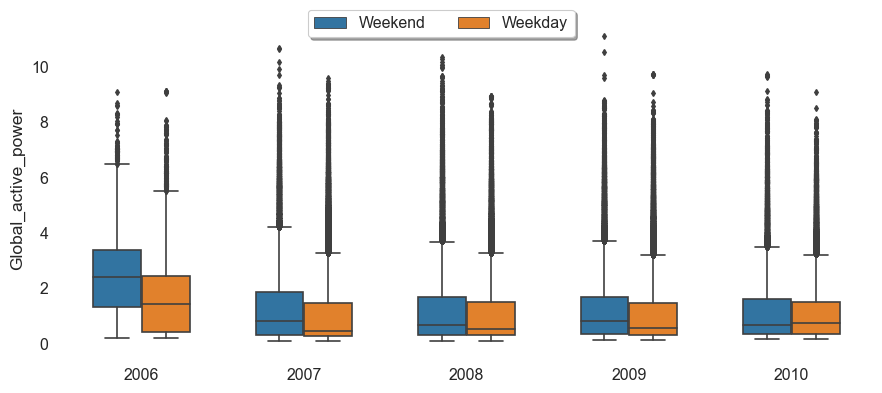

In [14]:
# Check power consumption during weekdays and weekends

dic = {0: 'Weekend', 1: 'Weekday'}
df['Day'] = df['weekday'].map(dic)

a = plt.figure(figsize=(9, 4))
plt1 = sns.boxplot(x='year', y='Global_active_power', hue='Day', width=0.6, fliersize=3, data=df)
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), shadow=True, ncol=2)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend().set_visible(False)


In [15]:
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday,Day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0,Weekend
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0,Weekend
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0,Weekend
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0,Weekend
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0,Weekend


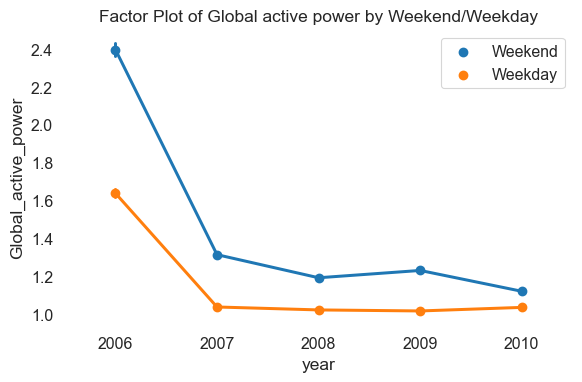

In [16]:
#biểu đồ dạng point plot của 'Global_active_power' được phân biệt theo 'Weekend' và 'Weekday' theo từng năm
import seaborn as sns
import matplotlib.pyplot as plt

dic = {0: 'Weekend', 1: 'Weekday'}
df['Day'] = df['weekday'].map(dic)

plt1 = sns.catplot(x='year', y='Global_active_power', hue='Day', data=df, kind='point', height=4, aspect=1.5, legend=False)
plt.title('Factor Plot of Global active power by Weekend/Weekday')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.legend(loc='upper right')

plt.show()


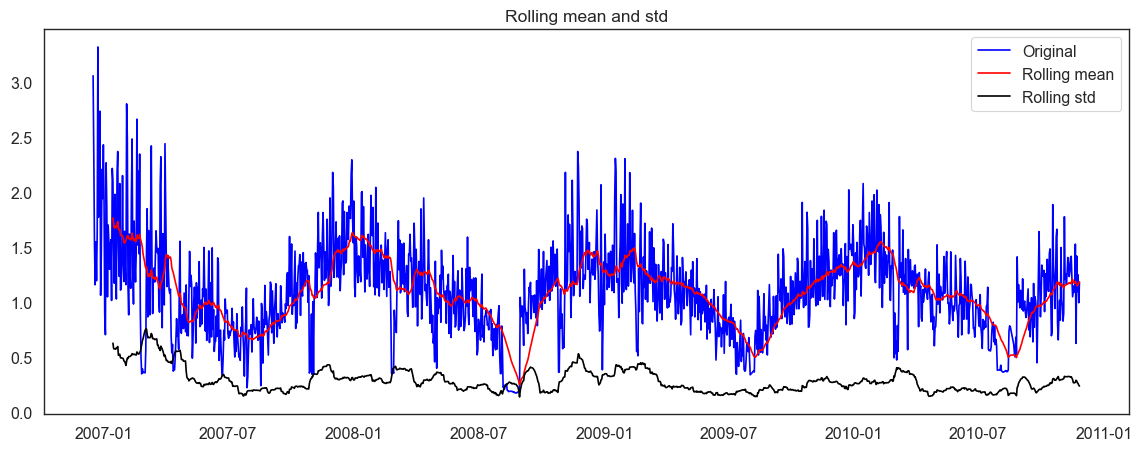

<Results of Dickey Fuller Test>
Test stastic                    -3.6842
p-value                          0.0043
#Lags Used                      22.0000
Number of observations used   1410.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [17]:
# biểu đồ dạng đường cho giá trị trung bình trượt và độ lệch chuẩn trượt của chuỗi thời gian được hiển thị
df2=df1.resample('D').mean()

def test_stationarity(timeseries):
  rolmean=timeseries.rolling(window=30).mean()
  rolstd=timeseries.rolling(window=30).std()

  plt.figure(figsize=(14,5))
  sns.despine(left=True)
  orig=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rolmean,color='red',label='Rolling mean')
  std=plt.plot(rolstd, color='black',label='Rolling std')

  plt.legend(loc='best')
  plt.title('Rolling mean and std')
  plt.show()

  print('<Results of Dickey Fuller Test>')
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],
                     index=['Test stastic','p-value','#Lags Used','Number of observations used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]=value
  print(dfoutput)
test_stationarity(df2.Global_active_power.dropna())

### LSTM model<a id="lstm"></a>

In [18]:
#Tạo một mảng numpy dataset từ cột 'Global_active_power' của DataFrame df.
dataset=df.Global_active_power.values
dataset=dataset.astype('float32')
#Thay đổi hình dạng của mảng dataset thành một mảng 2 chiều với một cột và số hàng tự động tính toán.
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
#Xác định kích thước của tập huấn luyện bằng 80% số lượng mẫu trong mảng dataset.
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
#Chia mảng dataset thành tập huấn luyện và tập kiểm tra dựa trên kích thước đã xác định ở các bước trước.
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]
# Định nghĩa một hàm create_dataset để tạo dữ liệu đầu vào và đầu ra cho mô hình dự đoán chuỗi thời gian. 
# Tham số dataset là mảng dữ liệu, và look_back là số lượng thời điểm quay lại để dự đoán thời điểm hiện tại.
def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs 
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [19]:
test.shape[0]

409856

Mô hình LSTM được xây dựng và huấn luyện trên dữ liệu chuỗi thời gian. Các lớp LSTM và Dense được sử dụng để học và dự đoán giá trị tiếp theo của chuỗi thời gian. Mất mát được tính bằng cách sử dụng hàm mất mát 'mean_squared_error' và quá trình tối ưu hóa được thực hiện bằng thuật toán 'adam'

In [20]:
# Tạo một mô hình tuần tự
model=tf.keras.Sequential()
#Thêm một lớp LSTM vào mô hình với 100 units và kích thước đầu vào là (x_train.shape[1], x_train.shape[2])
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
#Thêm một lớp Dropout với tỷ lệ 0.2 để tránh overfitting.
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#Huấn luyện mô hình trên dữ liệu huấn luyện và kiểm tra
history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
23420/23420 [==============================] - 52s 2ms/step - loss: 8.1431e-04 - val_loss: 4.0550e-04
Epoch 2/20
23420/23420 [==============================] - 60s 3ms/step - loss: 6.6981e-04 - val_loss: 4.0247e-04
Epoch 3/20
23420/23420 [==============================] - 50s 2ms/step - loss: 6.5592e-04 - val_loss: 3.9357e-04
Epoch 4/20
23420/23420 [==============================] - 51s 2ms/step - loss: 6.4254e-04 - val_loss: 4.0247e-04
Epoch 5/20
23420/23420 [==============================] - 52s 2ms/step - loss: 6.3730e-04 - val_loss: 3.9234e-04
Epoch 6/20
23420/23420 [==============================] - 58s 2ms/step - loss: 6.3401e-04 - val_loss: 4.0294e-04
Epoch 7/20
23420/23420 [==============================] - 56s 2ms/step - loss: 6.3364e-04 - val_loss: 3.9622e-04
Epoch 8/20
23420/23420 [==============================] - 58s 2ms/step - loss: 6.3189e-04 - val_loss: 3.9608e-04
Epoch 9/20
23420/23420 [==============================] - 61s 3ms/step - loss: 6.3007e-04 - val_

### PREDICTION<a id="prediction"></a>

In [21]:
# Dự đoán giá trị đầu ra trên tập huấn luyện bằng cách sử dụng phương thức predict() trên mô hình với đầu vào x_train.

train_predict = model.predict(x_train)
# Dự đoán giá trị đầu ra trên tập test bằng cách sử dụng phương thức predict() trên mô hình với đầu vào x_test.
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

12808/12808 [==============================] - 11s 829us/step
Train Mean Absolute Error: 0.09769495393223793
Train Root Mean Squared Error: 0.2679834986783785
Test Mean Absolute Error: 0.08234539613668194
Test Root Mean Squared Error: 0.2188219315424392


Vẽ biểu đồ mất mát của mô hình trên tập huấn luyện và tập kiểm tra 

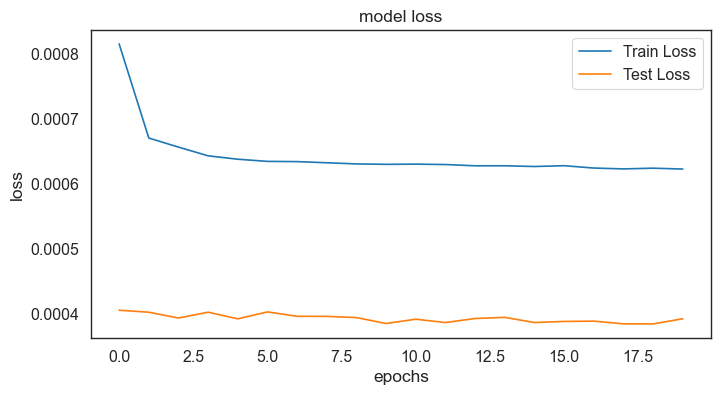

In [22]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán của chuỗi thời gian trên tập kiểm tra

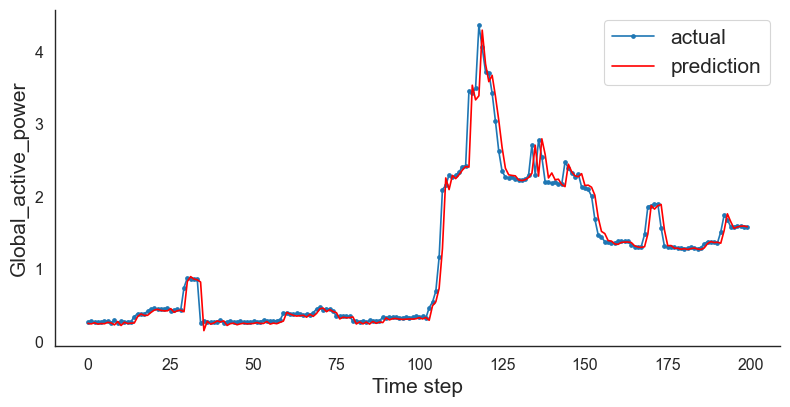

In [23]:
#Tạo một danh sách aa chứa các giá trị từ 0 đến 199.
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
#Vẽ đường cong các giá trị thực tế trên tập kiểm tra từ chỉ số 0 đến 199.
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();